# Biot problem: Convergence 

On the unit square domain $\Omega = (0,1) \times (0,1)$ and time interval $I = (0, 1)$ 
we consider the initial and boundary value problem (corresponding to Biot's poroelasticity system) assuming as 
analytical solution:
$$
    \begin{aligned}
      u_1 &= (e^{t} - 1) (\sin(2\pi y) (\cos(2 \pi x) - 1) + \frac1{\mu +\lambda} \sin(\pi x) \sin(\pi y)), \\
      u_2 &= (e^{t} - 1) (\sin(2\pi x) (1 - \cos(2 \pi y)) + \frac1{\mu +\lambda} \sin(\pi x) \sin(\pi y)), \\
      p &= (e^{t} - 1) \sin(\pi x) \sin(\pi y). 
    \end{aligned}
$$

Hence, we have $\boldsymbol{u}_{|\partial\Omega} = \boldsymbol{0}$, $p_{|\partial\Omega} = 0$, $\boldsymbol{u}(0) = \boldsymbol{u}_{0} = \boldsymbol{0}$, and $p(0) = p_{0} = 0$. The right-hand side terms inferred from the exact solution are
$$
    \begin{aligned}
      f_1 &= \pi(e^t - 1)(\alpha\cos(\pi x)\sin(\pi y) - \pi(\cos(\pi x+\pi y)+4\mu\sin(2\pi y)(1-2\cos(2\pi x)) -\frac{2\mu}{\mu +\lambda}\sin(\pi x) \sin(\pi y)), \\
      f_2 &= \pi(e^t - 1)(\alpha\sin(\pi x)\cos(\pi y) - \pi(\cos(\pi x+\pi y)+4\mu\sin(2\pi x)(2\cos(2\pi y)-1) -\frac{2\mu}{\mu +\lambda}\sin(\pi x) \sin(\pi y)), \\
      g &= (2\kappa\pi^2 (e^{t} - 1) + c_0 e^t) \sin(\pi x) \sin(\pi y) + \frac{\alpha\pi e^t}{\lambda + \mu} \sin(\pi x + \pi y). 
    \end{aligned}
$$

## Numerical solution and convergence performances

In [1]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# problem data
T = 0.6
lam = Constant(16)
c_0 = Constant(0.0)
kappa = Constant(0.0001)
alpha = Constant(0.01)  # declared as sqrt(kappa)

# volumetric forcing term
f1 = Expression((
    'pi*(exp(time)-1)*(cos(pi*x[0])*sin(pi*x[1]) -pi*(cos(pi*x[0]+pi*x[1])+4*sin(2*pi*x[1])*(1-2*cos(2*pi*x[0]))))', 
    'pi*(exp(time)-1)*(sin(pi*x[0])*cos(pi*x[1]) -pi*(cos(pi*x[0]+pi*x[1])+4*sin(2*pi*x[0])*(2*cos(2*pi*x[1])-1)))'
              ), degree=3, time=0.0)
f2 = Expression((
    '(2*_mu/(_mu+_lam))*pi*pi*(exp(time)-1)*(sin(pi*x[0])*sin(pi*x[1]))', 
    '(2*_mu/(_mu+_lam))*pi*pi*(exp(time)-1)*(sin(pi*x[0])*sin(pi*x[1]))'
              ), degree=3, time=0.0, _mu=1.0, _lam=lam)

# fluid source term
g1 = Expression('(_kappa*2*pi*pi*(exp(time)-1)+_c_0*exp(time))*sin(pi*x[0])*sin(pi*x[1])', degree=3, time=0.0, _kappa=kappa, _c_0=c_0) 
g2 = Expression('(pi/(_mu+_lam))*exp(time)*sin(pi*x[0]+pi*x[1])', degree=3, time=0.0, _mu=1.0, _lam=lam)

# analytical solutions (primary variables)
u_ex = Expression((
      '(exp(time)-1)*(sin(2*pi*x[1])*(cos(2*pi*x[0])-1) + (1.0/(_mu+_lam))*sin(pi*x[0])*sin(pi*x[1]))', 
      '(exp(time)-1)*(sin(2*pi*x[0])*(1-cos(2*pi*x[1])) + (1.0/(_mu+_lam))*sin(pi*x[0])*sin(pi*x[1]))'
              ), degree=4, time=0.0, _mu=1.0, _lam=lam)
p_ex = Expression('(exp(time)-1)*sin(pi*x[0])*sin(pi*x[1])', degree=4, time=0.0)

# analytical solutions (additional variables for "hybrid"-mixed formulations)
s1_ex = Expression((
      'pi*(exp(time)-1)*(-4*sin(2*pi*x[0])*sin(2*pi*x[1]) + (2.0/(1.0+_lam))*cos(pi*x[0])*sin(pi*x[1]) + (_lam/(1.0+_lam))*sin(pi*x[0]+pi*x[1]) - (1.0- _alpha)*sin(pi*x[0])*sin(pi*x[1])/pi)', 
      'pi*(exp(time)-1)*(2*cos(2*pi*x[0])-2*cos(2*pi*x[1]) + (1.0/(1.0+_lam))*sin(pi*x[0]+pi*x[1]))'
              ), degree=4, time=0.0, _lam=lam, _alpha=alpha)
s2_ex = Expression(( 
      'pi*(exp(time)-1)*(2*cos(2*pi*x[0])-2*cos(2*pi*x[1]) + (1.0/(1.0+_lam))*sin(pi*x[0]+pi*x[1]))',
      'pi*(exp(time)-1)*(4*sin(2*pi*x[0])*sin(2*pi*x[1]) + (2.0/(1.0+_lam))*sin(pi*x[0])*cos(pi*x[1]) + (_lam/(1.0+_lam))*sin(pi*x[0]+pi*x[1]) - (1.0- _alpha)*sin(pi*x[0])*sin(pi*x[1])/pi)',
              ), degree=4, time=0.0, _lam=lam, _alpha=alpha)
w_ex = Expression((
      '-_kappa*pi*(exp(time)-1)*(cos(pi*x[0])*sin(pi*x[1]))+exp(time)*_alpha*(sin(2*pi*x[1])*(cos(2*pi*x[0])-1) + (1.0/(1.0+_lam))*sin(pi*x[0])*sin(pi*x[1]))',
      '-_kappa*pi*(exp(time)-1)*(sin(pi*x[0])*cos(pi*x[1]))+exp(time)*_alpha*(sin(2*pi*x[0])*(1-cos(2*pi*x[1])) + (1.0/(1.0+_lam))*sin(pi*x[0])*sin(pi*x[1]))',
              ), degree=4, time=0.0, _kappa=kappa, _lam=lam, _alpha=alpha)

# analytical solutions (additional variables for mixed formulation Lee)
s1_et = Expression((
      'pi*(exp(time)-1)*(-4*sin(2*pi*x[0])*sin(2*pi*x[1]) + (2.0/(_mu+_lam))*cos(pi*x[0])*sin(pi*x[1]) + (_lam/(_mu+_lam))*sin(pi*x[0]+pi*x[1]) - sin(pi*x[0])*sin(pi*x[1])/pi)', 
      'pi*(exp(time)-1)*(2*cos(2*pi*x[0])-2*cos(2*pi*x[1]) + (1.0/(_mu+_lam))*sin(pi*x[0]+pi*x[1]))'
              ), degree=4, time=0.0, _mu=1.0, _lam=lam)
s2_et = Expression(( 
      'pi*(exp(time)-1)*(2*cos(2*pi*x[0])-2*cos(2*pi*x[1]) + (1.0/(_mu+_lam))*sin(pi*x[0]+pi*x[1]))',
      'pi*(exp(time)-1)*(4*sin(2*pi*x[0])*sin(2*pi*x[1]) + (2.0/(_mu+_lam))*sin(pi*x[0])*cos(pi*x[1]) + (_lam/(_mu+_lam))*sin(pi*x[0]+pi*x[1]) - sin(pi*x[0])*sin(pi*x[1])/pi)',
              ), degree=4, time=0.0, _mu=1.0, _lam=lam)
w_et = Expression(( 
      '-_kappa*pi*(exp(time)-1)*(cos(pi*x[0])*sin(pi*x[1]))',
      '-_kappa*pi*(exp(time)-1)*(sin(pi*x[0])*cos(pi*x[1]))',
              ), degree=4, time=0.0, _kappa=kappa, _mu=1.0, _lam=lam)

### 3 field-formualtion with total pressure

In [ ]:
def solve_biot3f(n, dt, T, lam, c_0, kappa, u_ex, p_ex, f1, f2, g1, g2):
    # 0. method specific pre-computations
    beta = c_0 + 1.0/lam
    
    # 1. mesh generation
    #mesh = UnitSquareMesh(n, n, 'crossed')
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    mesh = generate_mesh(square, n)

    # 2. definition of the lowest-order Taylor-Hood finite element pair
    U = VectorElement('CG', mesh.ufl_cell(), 2)
    Q = FiniteElement('CG', mesh.ufl_cell(), 1)
    #B = FiniteElement('Bubble', mesh.ufl_cell(), mesh.topology().dim() + 1)
    #U = VectorElement(NodalEnrichedElement(Q, B))
    P = FiniteElement('CG', mesh.ufl_cell(), 2)
    X = FunctionSpace(mesh, MixedElement([U, Q, P]))

    def boundary(x, on_boundary):
        return on_boundary
    bc_u = DirichletBC(X.sub(0), Constant((0.0, 0.0)), boundary)
    bc_p = DirichletBC(X.sub(2), 0.0, boundary)

    # 3. assembling 
    u, phi, p = TrialFunctions(X)
    v, psi, q = TestFunctions(X)
    x_old = Function(X)
    u_old, phi_old, p_old = split(x_old)
    
    a1 = (2.0 * inner(sym(grad(u)), sym(grad(v))) - phi * div(v)) * dx
    a2 = (div(u) + phi/lam - p/lam) * psi * dx
    a3 = (-phi * q/lam + beta * p * q + dt * inner(kappa*grad(p), grad(q))) * dx
    a = a1 + a2 + a3
    L = (dot(f1+f2, v) + dt*(g1+g2)*q - phi_old*q/lam + beta*p_old*q) * dx 

    # 4. solve and advance in time 
    A = assemble(a)
    bc_u.apply(A)
    bc_p.apply(A)
    Ainv = LUSolver(A)
    
    #size_A = A.array().shape
    #nnz_A = np.count_nonzero(A.array())

    l2err_u = 0.0
    h1err_u = 0.0
    l2err_p = 0.0
    h1err_p = 0.0

    for t in np.arange(dt, T+0.1*dt, dt):
        f1.time = t
        f2.time = t
        g1.time = t
        g2.time = t
        b = assemble(L)
        bc_u.apply(b)
        bc_p.apply(b)
        
        print('solving time {}'.format(t))
        Ainv.solve(x_old.vector(), b)
        u_old, phi_old, p_old = x_old.split()

        u_ex.time = t
        p_ex.time = t
        l2err_u = max(l2err_u, errornorm(u_ex, u_old, 'L2'))
        h1err_u += dt * (errornorm(u_ex, u_old, 'H10')**2)
        l2err_p = max(l2err_p, errornorm(p_ex, p_old, 'L2'))
        h1err_p += dt * (errornorm(p_ex, p_old, 'H10')**2)
    
    h1err_u = sqrt(h1err_u)
    h1err_p = sqrt(h1err_p)
    return l2err_u, h1err_u, l2err_p, h1err_p

In [ ]:
M_err=np.zeros((4,4))

for i in range(4):
    n = 5*(2**i)
    dt = 0.3/(4**i)
    l2err_u, h1err_u, l2err_p, h1err_p = solve_biot3f(n, dt, T, lam, c_0, kappa, u_ex, p_ex, f1, f2, g1, g2)

    M_err[0,i] = l2err_u 
    M_err[1,i] = h1err_u
    M_err[2,i] = l2err_p 
    M_err[3,i] = h1err_p

    print('n={} dt={} l2err_u={:.2e} h1err_u={:.2e} l2err_p={:.2e} h1err_p={:.2e}'.format(n, dt, l2err_u, h1err_u, l2err_p, h1err_p))
    print()

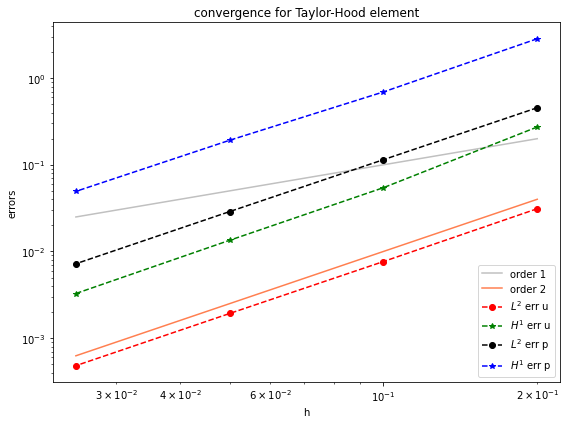

In [ ]:
# definition of the meshsize 
h = np.array([0.2/(2**i) for i in range(4)])

# we use the subplots axis layout managers in matplotlib
fig, axes = plt.subplots(figsize=(8,6))

axes.loglog(h, h, 'silver',label="order 1")
axes.loglog(h, h**2, 'coral',label="order 2")
axes.loglog(h, M_err[0,:], 'r--o',label="$L^2$ err u")
axes.loglog(h, M_err[1,:], 'g--*',label="$H^1$ err u")
axes.loglog(h, M_err[2,:], 'k--o',label="$L^2$ err p")
axes.loglog(h, M_err[3,:], 'b--*',label="$H^1$ err p")

axes.set_title("convergence for Taylor-Hood element");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.tight_layout()
plt.show()

### 2 field-formualtion with hybrid pressure

In [ ]:
def solve_biot2h(n, dt, T, lam, c_0, kappa, u_ex, p_ex, f1, f2, g1, g2):
    
    # 1. mesh generation
    #mesh = UnitSquareMesh(n, n, 'crossed')
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    mesh = generate_mesh(square, n)

    # 2. definition of the lowest-order element
    U = VectorElement('CG', mesh.ufl_cell(), 1)
    P = FiniteElement('CG', mesh.ufl_cell(), 1)
    X = FunctionSpace(mesh, MixedElement([U, P]))

    def boundary(x, on_boundary):
        return on_boundary
    bc_u = DirichletBC(X.sub(0), Constant((0.0, 0.0)), boundary)
    bc_p = DirichletBC(X.sub(1), 0.0, boundary)

    # 3. assembling 
    u, p = TrialFunctions(X)
    v, q = TestFunctions(X)
    x_old = Function(X)
    u_old, p_old = split(x_old)
    
    a1 = (2.0 * inner(sym(grad(u)), sym(grad(v))) + lam * div(u) * div(v)) * dx
    a2 = ((1.0-alpha) * div(u) * q - (1.0-alpha) * div(v) * p) * dx
    a3 = (dot(alpha * grad(p), v) - dot(alpha * grad(q), u)) * dx
    a4 = (c_0 * p * q + dt * inner(kappa*grad(p), grad(q))) * dx
    a = a1 + a2 + a3 + a4
    L = (dot(f1+f2, v) + dt*(g1+g2)*q + (1.0-alpha) * div(u_old) * q + c_0*p_old*q - dot(alpha * grad(q), u_old)) * dx 

    # 4. solve and advance in time 
    A = assemble(a)
    bc_u.apply(A)
    bc_p.apply(A)
    Ainv = LUSolver(A)

    l2err_u = 0.0
    h1err_u = 0.0
    l2err_p = 0.0
    h1err_p = 0.0

    for t in np.arange(dt, T+0.1*dt, dt):
        f1.time = t
        f2.time = t
        g1.time = t
        g2.time = t
        b = assemble(L)
        bc_u.apply(b)
        bc_p.apply(b)
        
        print('solving time {}'.format(t))
        Ainv.solve(x_old.vector(), b)
        u_old, p_old = x_old.split()

        u_ex.time = t
        p_ex.time = t
        l2err_u = max(l2err_u, errornorm(u_ex, u_old, 'L2'))
        h1err_u += dt * (errornorm(u_ex, u_old, 'H10')**2)
        l2err_p = max(l2err_p, errornorm(p_ex, p_old, 'L2'))
        h1err_p += alpha * dt * (errornorm(p_ex, p_old, 'H10')**2)
    
    h1err_u = sqrt(h1err_u)
    h1err_p = sqrt(h1err_p)
    return l2err_u, h1err_u, l2err_p, h1err_p

In [ ]:
M_err=np.zeros((4,4))

for i in range(4):
    n = 6*(2**i)
    dt = 0.3/(2**i)
    l2err_u, h1err_u, l2err_p, h1err_p = solve_biot2h(n, dt, T, lam, c_0, kappa, u_ex, p_ex, f1, f2, g1, g2)

    M_err[0,i] = l2err_u 
    M_err[1,i] = h1err_u
    M_err[2,i] = l2err_p 
    M_err[3,i] = h1err_p

    print('n={} dt={} l2err_u={:.2e} h1err_u={:.2e} l2err_p={:.2e} '.format(n, dt, l2err_u, h1err_u, l2err_p))
    print()

solving time 0.3
solving time 0.6
n=6 dt=0.3 l2err_u=1.64e-01 h1err_u=1.41e+00 l2err_p=2.30e-01 

solving time 0.15
solving time 0.3
solving time 0.44999999999999996
solving time 0.6
n=12 dt=0.15 l2err_u=4.18e-02 h1err_u=5.96e-01 l2err_p=1.01e-01 

solving time 0.075
solving time 0.15
solving time 0.22499999999999998
solving time 0.3
solving time 0.375
solving time 0.45
solving time 0.5249999999999999
solving time 0.6
n=24 dt=0.075 l2err_u=1.02e-02 h1err_u=2.71e-01 l2err_p=4.92e-02 

solving time 0.0375
solving time 0.075
solving time 0.11249999999999999
solving time 0.15
solving time 0.1875
solving time 0.225
solving time 0.26249999999999996
solving time 0.3
solving time 0.33749999999999997
solving time 0.37499999999999994
solving time 0.4125
solving time 0.44999999999999996
solving time 0.48749999999999993
solving time 0.525
solving time 0.5625
solving time 0.6
n=48 dt=0.0375 l2err_u=2.74e-03 h1err_u=1.28e-01 l2err_p=2.42e-02 



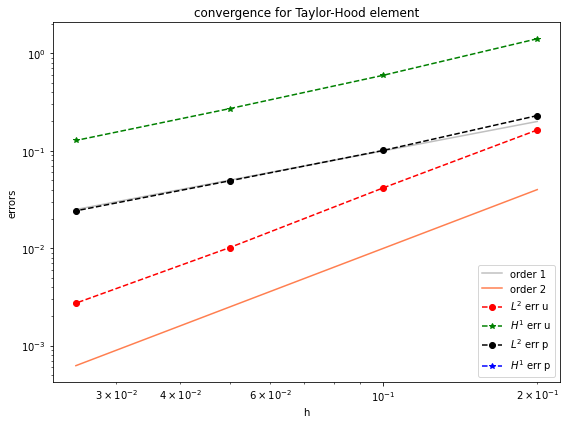

In [ ]:
# definition of the meshsize 
h = np.array([0.2/(2**i) for i in range(4)])

# we use the subplots axis layout managers in matplotlib
fig, axes = plt.subplots(figsize=(8,6))

axes.loglog(h, h, 'silver',label="order 1")
axes.loglog(h, h**2, 'coral',label="order 2")
axes.loglog(h, M_err[0,:], 'r--o',label="$L^2$ err u")
axes.loglog(h, M_err[1,:], 'g--*',label="$H^1$ err u")
axes.loglog(h, M_err[2,:], 'k--o',label="$L^2$ err p")
axes.loglog(h, M_err[3,:], 'b--*',label="$H^1$ err p")

axes.set_title("convergence for Taylor-Hood element");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.tight_layout()
plt.show()

### 4-field formulation with hybrid pressure and flux

In [ ]:
def solve_biot4h(n, dt, T, lam, c_0, kappa, alpha, u_ex, p_ex, w_ex, f1, f2, g1, g2):
    # 1. mesh generation
    #mesh = UnitSquareMesh(n, n, 'crossed')
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    mesh = generate_mesh(square, n)

    # 2. definition of the lowest-order Taylor-Hood finite element pair
    #U = VectorElement('CG', mesh.ufl_cell(), 2)
    Q = FiniteElement('CG', mesh.ufl_cell(), 1)
    B = FiniteElement('Bubble', mesh.ufl_cell(), mesh.topology().dim() + 1)
    U = VectorElement(NodalEnrichedElement(Q, B))
    W = FiniteElement('RT', mesh.ufl_cell(), 1)
    P = FiniteElement('DG', mesh.ufl_cell(), 0)
    X = FunctionSpace(mesh, MixedElement([U, Q, W, P]))

    def boundary(x, on_boundary):
        return on_boundary
    bc_u = DirichletBC(X.sub(0), Constant((0.0, 0.0)), boundary)

    # 3. assembling 
    u, phi, w, p = TrialFunctions(X)
    v, psi, z, q = TestFunctions(X)
    x_old = Function(X)
    u_old, phi_old, w_old, p_old = split(x_old)
    
    a1 = (2.0 * inner(sym(grad(u)), sym(grad(v))) - phi * div(v) + psi * div(u)) * dx
    a2 = (1.0/lam) * (phi - (1.0-alpha) * p) * (psi - (1.0-alpha) * q) * dx
    a3 = (dt/kappa) * dot(w - (alpha/dt)*u, z - (alpha/dt)*v) * dx
    a4 = (dt * q * div(w) - dt * p * div(z) + c_0 * p * q)  * dx
    a = a1 + a2 + a3 + a4
    
    L1 = (dot(f1+f2, v)  - (alpha/kappa)*dot(u_old, z-(alpha/dt)*v)) * dx 
    L2 = (dt*(g1+g2) - ((1.0-alpha)/lam)*(phi_old - (1.0-alpha)*p_old) + c_0*p_old) * q * dx
    L = L1 + L2
    
    # 4. solve and advance in time 
    A = assemble(a)
    bc_u.apply(A)
    Ainv = LUSolver(A)

    l2err_u = 0.0
    h1err_u = 0.0
    l2err_p = 0.0
    l2err_w = 0.0
    Hdiverr_w = 0.0

    for t in np.arange(dt, T+0.1*dt, dt):
        f1.time = t
        f2.time = t
        g1.time = t
        g2.time = t
        b = assemble(L)
        bc_u.apply(b)
        
        print('solving time {}'.format(t))
        Ainv.solve(x_old.vector(), b)
        u_old, phi_old, w_old, p_old = x_old.split()

        u_ex.time = t
        p_ex.time = t
        w_ex.time = t
        l2err_u = max(l2err_u, errornorm(u_ex, u_old, 'L2'))
        h1err_u += dt * (errornorm(u_ex, u_old, 'H10')**2)
        l2err_p = max(l2err_p, errornorm(p_ex, p_old, 'L2'))
        l2err_w = max(l2err_w, errornorm(w_ex, w_old, 'L2'))
        Hdiverr_w += dt * (errornorm(w_ex, w_old, 'Hdiv0')**2)
    
    h1err_u = sqrt(h1err_u)
    Hdiverr_w = sqrt(Hdiverr_w)
    return l2err_u, h1err_u, l2err_p, l2err_w, Hdiverr_w

In [ ]:
M_err=np.zeros((5,4))

for i in range(4):
    n = 6*(2**i)
    dt = 0.2/(2**i)
    l2err_u, h1err_u, l2err_p, l2err_w, Hdiverr_w = solve_biot4h(n, dt, T, lam, c_0, kappa, alpha, u_ex, p_ex, w_ex, f1, f2, g1, g2)

    M_err[0,i] = l2err_u 
    M_err[1,i] = h1err_u
    M_err[2,i] = l2err_p 
    M_err[3,i] = l2err_w
    M_err[4,i] = Hdiverr_w

    print('n={} dt={} l2err_u={:.2e} h1err_u={:.2e} l2err_p={:.2e} l2err_w={:.2e} Hdiverr_w={:.2e}'.format(n, dt, l2err_u, h1err_u, l2err_p, l2err_w, Hdiverr_w))
    print()

solving time 0.2
solving time 0.4
solving time 0.6000000000000001
n=6 dt=0.2 l2err_u=1.25e-01 h1err_u=1.15e+00 l2err_p=1.91e-01 l2err_w=2.32e-02 Hdiverr_w=3.20e-01

solving time 0.1
solving time 0.2
solving time 0.30000000000000004
solving time 0.4
solving time 0.5
solving time 0.6
n=12 dt=0.1 l2err_u=3.14e-02 h1err_u=5.14e-01 l2err_p=7.50e-02 l2err_w=7.10e-03 Hdiverr_w=1.39e-01

solving time 0.05
solving time 0.1
solving time 0.15000000000000002
solving time 0.2
solving time 0.25
solving time 0.3
solving time 0.35000000000000003
solving time 0.4
solving time 0.45
solving time 0.5
solving time 0.55
solving time 0.6000000000000001
n=24 dt=0.05 l2err_u=7.73e-03 h1err_u=2.40e-01 l2err_p=3.58e-02 l2err_w=2.76e-03 Hdiverr_w=5.43e-02

solving time 0.025
solving time 0.05
solving time 0.07500000000000001
solving time 0.1
solving time 0.125
solving time 0.15
solving time 0.17500000000000002
solving time 0.2
solving time 0.225
solving time 0.25
solving time 0.275
solving time 0.3000000000000000

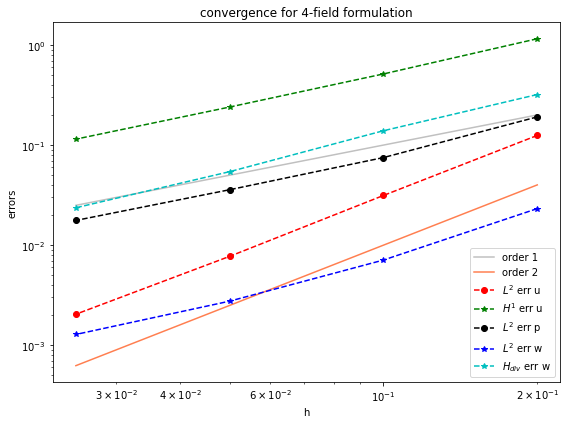

In [ ]:
# definition of the meshsize 
h = np.array([0.2/(2**i) for i in range(4)])

# we use the subplots axis layout managers in matplotlib
fig, axes = plt.subplots(figsize=(8,6))

axes.loglog(h, h, 'silver',label="order 1")
axes.loglog(h, h**2, 'coral',label="order 2")
axes.loglog(h, M_err[0,:], 'r--o',label="$L^2$ err u")
axes.loglog(h, M_err[1,:], 'g--*',label="$H^1$ err u")
axes.loglog(h, M_err[2,:], 'k--o',label="$L^2$ err p")
axes.loglog(h, M_err[3,:], 'b--*',label="$L^2$ err w")
axes.loglog(h, M_err[4,:], 'c--*',label="$H_{div}$ err w")

axes.set_title("convergence for 4-field formulation");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.tight_layout()
plt.show()

### 4-field formulation with weakly symmetric hybrid stress

In [ ]:
def solve_biot4f(n, dt, T, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, f1, f2, g1, g2):
    # 0. method specific pre-computations
    beta = (1.0-alpha)/(2*(1.0+lam))
    gamma = lam/(4*(1.0+lam))
    c_1 = c_0 + ((1.0-alpha)**2)/(1.0+lam)
    
    # 1. mesh generation
    #mesh = UnitSquareMesh(n, n, 'crossed')
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    mesh = generate_mesh(square, n)

    # 2. definition of a weak symmetry MFE stable coupling
    S1 = FiniteElement('BDM', mesh.ufl_cell(), 1)
    S2 = FiniteElement('BDM', mesh.ufl_cell(), 1)
    U = VectorElement('DG', mesh.ufl_cell(), 0)
    Q = FiniteElement('DG', mesh.ufl_cell(), 0)
    P = FiniteElement('CG', mesh.ufl_cell(), 1)
    X = FunctionSpace(mesh, MixedElement([S1, S2, U, Q, P]))
    
    # 3. assembling     
    s1, s2, u, w, p = TrialFunctions(X)
    t1, t2, v, z, q = TestFunctions(X)

    x_old = Function(X)
    s1_old, s2_old, u_old, w_old, p_old = split(x_old)
    
    a1 = (0.5 * (dot(s1, t1)+dot(s2, t2)) - gamma * (s1[0]+s2[1]) * (t1[0]+t2[1])) * dx
    a2 = (u[0] * div(t1) + u[1] * div(t2) + v[0] * div(s1) + v[1] * div(s2)) * dx   
    a3 = beta * ((t1[0]+t2[1]) * p + (s1[0]+s2[1]) * q) * dx
    a4 = -(dot(alpha * grad(p), v) + dot(alpha * grad(q), u)) * dx
    a5 = (c_1 * p * q + dt * inner(kappa*grad(p), grad(q))) * dx
    a6 = (z * (s1[1] - s2[0]) + w * (t1[1] - t2[0])) * dx 
    a = a1 + a2 + a3 + a4 + a5 + a6
    
    L = ((dt*(g1+g2)+c_1*p_old + beta*(s1_old[0]+s2_old[1]))*q - dot(alpha*grad(q),u_old) - dot(f1+f2,v))*dx

    # 4. solve and advance in time 
    A = assemble(a)
    Ainv = LUSolver(A)
    
    # 5. Error evaluation
    l2err_u = 0.0
    l2err_s = 0.0
    Hdiverr_s = 0.0
    l2err_p = 0.0
    H1err_p = 0.0
    
    Y = FunctionSpace(mesh, 'DG', 1)
    l2err_q = 0.0

    for t in np.arange(dt, T+0.1*dt, dt):
        f1.time = t
        f2.time = t
        g1.time = t
        g2.time = t
        b = assemble(L)
        
        print('solving time {}'.format(t))
        Ainv.solve(x_old.vector(), b)
        s1_old, s2_old, u_old, w_old, p_old = x_old.split()

        u_ex.time = t
        p_ex.time = t
        s1_ex.time = t
        s2_ex.time = t
        l2err_u = max(l2err_u, errornorm(u_ex, u_old, 'L2'))
        l2err_s += dt * (errornorm(s1_ex, s1_old, 'L2')**2)
        l2err_s += dt * (errornorm(s2_ex, s2_old, 'L2')**2)
        Hdiverr_s += dt * (errornorm(s1_ex, s1_old, 'Hdiv0')**2)
        Hdiverr_s += dt * (errornorm(s2_ex, s2_old, 'Hdiv0')**2)
        l2err_p = max(l2err_p, errornorm(p_ex, p_old, 'L2'))
        H1err_p += dt * (errornorm(p_ex, p_old, 'H10')**2)
        
        qproj = project(s1_old[1] - s2_old[0], Y)
        l2err_q += dt * (norm(qproj, 'L2')**2)
    
    l2err_s = sqrt(l2err_s)
    Hdiverr_s = sqrt(Hdiverr_s)
    l2err_q = sqrt(l2err_q)
    H1err_p = sqrt(H1err_p)
    
    return l2err_u, l2err_s, l2err_p, l2err_q, Hdiverr_s, H1err_p

In [ ]:
M_err=np.zeros((6,4))

for i in range(4):
    n = 8*(2**i)
    dt = 0.2/(2**i)
    l2err_u, l2err_s, l2err_p, l2err_q, Hdiverr_s, H1err_p = solve_biot4f(n, dt, T, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, f1, f2, g1, g2)

    M_err[0,i] = l2err_u 
    M_err[1,i] = l2err_s
    M_err[2,i] = l2err_p 
    M_err[3,i] = l2err_q
    M_err[4,i] = Hdiverr_s
    M_err[5,i] = H1err_p

    print('l2err_u={:.2e} l2err_s={:.2e} l2err_p={:.2e} l2err_w={:.2e}'.format(l2err_u, l2err_s, l2err_p, l2err_q))
    print('n={} dt={} Hdiverr_s={:.2e} H1err_p={:.2e}'.format(n, dt, Hdiverr_s, H1err_p))
    print()

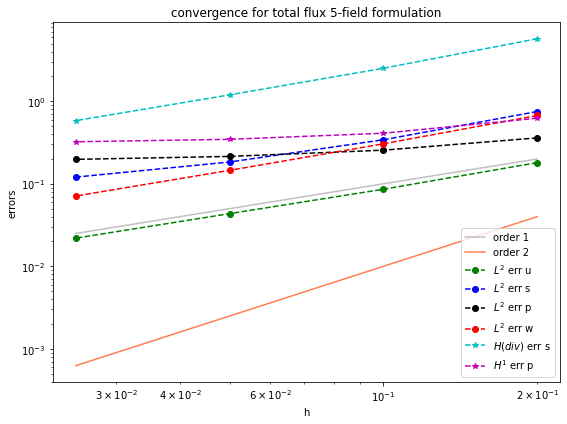

In [ ]:
# definition of the meshsize 
h = np.array([0.2/(2**i) for i in range(4)])

# we use the subplots axis layout managers in matplotlib
fig, axes = plt.subplots(figsize=(8,6))

axes.loglog(h, h, 'silver',label="order 1")
axes.loglog(h, h**2, 'coral',label="order 2")
axes.loglog(h, M_err[0,:], 'g--o',label="$L^2$ err u")
axes.loglog(h, M_err[1,:], 'b--o',label="$L^2$ err s")
axes.loglog(h, M_err[2,:], 'k--o',label="$L^2$ err p")
axes.loglog(h, M_err[3,:], 'r--o',label="$L^2$ err w")
axes.loglog(h, M_err[4,:], 'c--*',label="$H(div)$ err s")
axes.loglog(h, M_err[5,:], 'm--*',label="$H^1$ err p")

axes.set_title("convergence for total flux 5-field formulation");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.tight_layout()
plt.show()

### 5-field formulation with positive reaction terms (modified flux and stress)

In [ ]:
def solve_biot5f(n, dt, T, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2):
    # 0. method specific pre-computations
    beta = (1.0-alpha)/(2*(1.0+lam))
    gamma = lam/(4*(1.0+lam))
    c_1 = c_0 + ((1.0-alpha)**2)/(1.0+lam)
    
    # 1. mesh generation
    mesh = UnitSquareMesh(n, n, 'crossed')
    #square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    #mesh = generate_mesh(square, n)

    # 2. definition of a weak symmetry MFE stable coupling
    #S1 = VectorElement('CG', mesh.ufl_cell(), 2)
    #S2 = VectorElement('CG', mesh.ufl_cell(), 2)
    S1 = FiniteElement('RT', mesh.ufl_cell(), 2)
    S2 = FiniteElement('RT', mesh.ufl_cell(), 2)
    U = VectorElement('DG', mesh.ufl_cell(), 1)
    Q = FiniteElement('CG', mesh.ufl_cell(), 1)
    W = FiniteElement('RT', mesh.ufl_cell(), 2)
    P = FiniteElement('DG', mesh.ufl_cell(), 1)
    X = FunctionSpace(mesh, MixedElement([S1, S2, U, Q, W, P]))
    
    # 3. assembling     
    s1, s2, u, q, w, phi = TrialFunctions(X)
    t1, t2, v, r, z, psi = TestFunctions(X)

    x_old = Function(X)
    s1_old, s2_old, u_old, q_old, w_old, phi_old = split(x_old)
    
    a1 = (0.5 * (dot(s1, t1)+dot(s2, t2)) - gamma * (s1[0]+s2[1]) * (t1[0]+t2[1])) * dx
    a2 = (u[0] * div(t1) + u[1] * div(t2) + v[0] * div(s1) + v[1] * div(s2)) * dx   
    a3 = beta * ((t1[0]+t2[1]) * phi + (s1[0]+s2[1]) * psi) * dx
    a4 = -(dt/kappa) * dot(w - (alpha/dt)*u, z - (alpha/dt)*v) * dx
    a5 = (dt * psi * div(w) + dt * phi * div(z) + c_1 * phi * psi)  * dx
    a6 = (r * (s1[1] - s2[0]) + q * (t1[1] - t2[0])) * dx 
    a = a1 + a2 + a3 + a4 + a5 + a6
    
    L = ((dt*(g1+g2)+c_1*phi_old + beta*(s1_old[0]+s2_old[1]))*psi - dot(f1+f2,v) + (alpha/kappa)*dot(u_old, z-(alpha/dt)*v))*dx

    # 4. solve and advance in time 
    A = assemble(a)
    Ainv = LUSolver(A)
    
    # 5. Error evaluation
    l2err_u = 0.0
    l2err_s = 0.0
    Hdiverr_s = 0.0
    l2err_p = 0.0
    l2err_w = 0.0
    Hdiverr_w = 0.0
    
    Y = FunctionSpace(mesh, 'DG', 1)
    l2err_q = 0.0

    for t in np.arange(dt, T+0.1*dt, dt):
        f1.time = t
        f2.time = t
        g1.time = t
        g2.time = t
        b = assemble(L)
        
        print('solving time {}'.format(t))
        Ainv.solve(x_old.vector(), b)
        s1_old, s2_old, u_old, q_old, w_old, phi_old = x_old.split()

        u_ex.time = t
        p_ex.time = t
        s1_ex.time = t
        s2_ex.time = t
        w_ex.time = t
        l2err_u = max(l2err_u, errornorm(u_ex, u_old, 'L2'))
        l2err_s += dt * (errornorm(s1_ex, s1_old, 'L2')**2)
        l2err_s += dt * (errornorm(s2_ex, s2_old, 'L2')**2)
        Hdiverr_s += dt * (errornorm(s1_ex, s1_old, 'Hdiv0')**2)
        Hdiverr_s += dt * (errornorm(s2_ex, s2_old, 'Hdiv0')**2)
        l2err_p = max(l2err_p, errornorm(p_ex, phi_old, 'L2'))
        l2err_w += dt * (errornorm(w_ex, w_old, 'L2')**2)
        Hdiverr_w += dt * (errornorm(w_ex, w_old, 'Hdiv0')**2)
        
        qproj = project(s1_old[1] - s2_old[0], Y)
        l2err_q += dt * (norm(qproj, 'L2')**2)
    
    l2err_s = sqrt(l2err_s)
    Hdiverr_w = sqrt(Hdiverr_w)
    l2err_w = sqrt(l2err_w)
    Hdiverr_s = sqrt(Hdiverr_s)
    l2err_q = sqrt(l2err_q)
    
    return l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w

In [ ]:
M_err=np.zeros((7,4))

for i in range(4):
    n = 4*(2**i)
    dt = 0.3/(4**i)
    l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w = solve_biot5f(n, dt, T, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2)

    M_err[0,i] = l2err_u 
    M_err[1,i] = l2err_s
    M_err[2,i] = l2err_p 
    M_err[3,i] = l2err_w
    M_err[4,i] = l2err_q
    M_err[5,i] = Hdiverr_s
    M_err[6,i] = Hdiverr_w

    print('n={} l2err_u={:.2e} l2err_s={:.2e} l2err_p={:.2e} l2err_w={:.2e}'.format(n, l2err_u, l2err_s, l2err_p, l2err_w))
    print('dt={} l2err_q={:.2e} Hdiverr_s={:.2e} Hdiverr_w={:.2e} '.format(dt, l2err_q, Hdiverr_s, Hdiverr_w))
    print()

/usr/lib/python3/dist-packages/FIAT/check_format_variant.py:10: DeprecationWarning: Variant of Raviart Thomas element will change from point evaluation to integral evaluation. You should project into variant="integral"
  ' You should project into variant="integral"', DeprecationWarning)


solving time 0.3
solving time 0.6
n=4 l2err_u=5.31e-02 l2err_s=4.99e-01 l2err_p=3.11e-01 l2err_w=2.35e-03
dt=0.3 l2err_q=4.06e-01 Hdiverr_s=2.04e+00 Hdiverr_w=1.27e-02 

solving time 0.075
solving time 0.15
solving time 0.22499999999999998
solving time 0.3
solving time 0.375
solving time 0.45
solving time 0.5249999999999999
solving time 0.6
n=8 l2err_u=1.32e-02 l2err_s=8.75e-02 l2err_p=7.44e-02 l2err_w=5.54e-04
dt=0.075 l2err_q=6.03e-02 Hdiverr_s=4.01e-01 Hdiverr_w=4.30e-03 

solving time 0.01875
solving time 0.0375
solving time 0.056249999999999994
solving time 0.075
solving time 0.09375
solving time 0.1125
solving time 0.13124999999999998
solving time 0.15
solving time 0.16874999999999998
solving time 0.18749999999999997
solving time 0.20625
solving time 0.22499999999999998
solving time 0.24374999999999997
solving time 0.2625
solving time 0.28125
solving time 0.3
solving time 0.31875
solving time 0.33749999999999997
solving time 0.35624999999999996
solving time 0.375
solving time 0.3

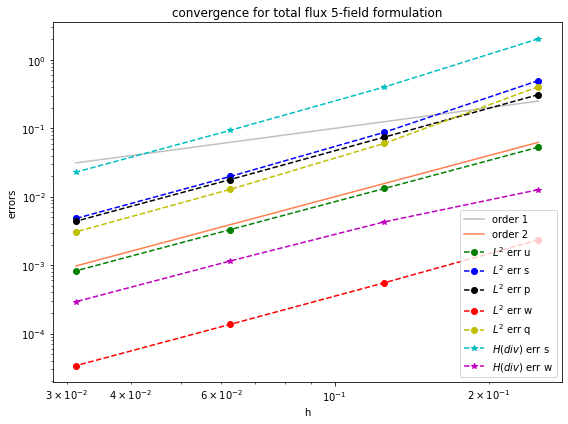

In [ ]:
# definition of the meshsize 
h = np.array([0.25/(2**i) for i in range(4)])

# we use the subplots axis layout managers in matplotlib
fig, axes = plt.subplots(figsize=(8,6))

axes.loglog(h, h, 'silver',label="order 1")
axes.loglog(h, h**2, 'coral',label="order 2")
axes.loglog(h, M_err[0,:], 'g--o',label="$L^2$ err u")
axes.loglog(h, M_err[1,:], 'b--o',label="$L^2$ err s")
axes.loglog(h, M_err[2,:], 'k--o',label="$L^2$ err p")
axes.loglog(h, M_err[3,:], 'r--o',label="$L^2$ err w")
axes.loglog(h, M_err[4,:], 'y--o',label="$L^2$ err q")
axes.loglog(h, M_err[5,:], 'c--*',label="$H(div)$ err s")
axes.loglog(h, M_err[6,:], 'm--*',label="$H(div)$ err w")

axes.set_title("convergence for total flux 5-field formulation");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.tight_layout()
plt.show()

### 4-field formulation with strong symmetry

In [ ]:
def solve_biot4s(n, dt, T, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2):
    # 0. method specific pre-computations
    beta = (1.0-alpha)/(2*(1.0+lam))
    gamma = lam/(4*(1.0+lam))
    c_1 = c_0 + ((1.0-alpha)**2)/(1.0+lam)
    
    # 1. mesh generation
    #mesh = UnitSquareMesh(n, n, 'crossed')
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    mesh = generate_mesh(square, n)

    # 2. definition of a weak symmetry MFE stable coupling
    S = TensorElement('CG', mesh.ufl_cell(), 2, symmetry=True)
    U = VectorElement('DG', mesh.ufl_cell(), 1)
    W = FiniteElement('RT', mesh.ufl_cell(), 1)
    P = FiniteElement('DG', mesh.ufl_cell(), 0)
    X = FunctionSpace(mesh, MixedElement([S, U, W, P]))
    
    # 3. assembling     
    s, u, w, p = TrialFunctions(X)
    t, v, z, q = TestFunctions(X)
    
    x_old = Function(X)
    s_old, u_old, w_old, p_old = split(x_old)
    
    a1 = (0.5 * inner(s, t) - gamma * tr(s) * tr(t) + beta * tr(t) * p + beta * tr(s) * q + c_1 * p * q) * dx
    a2 = (dot(u, div(t)) + dot(v, div(s)) + dt * q * div(w) + dt * p * div(z)) * dx   
    a3 = -(dt/kappa) * dot(w - (alpha/dt)*u, z - (alpha/dt)*v) * dx
    a = a1 + a2 + a3
    
    L = ((dt*(g1+g2)+c_1*p_old+beta*tr(s_old))*q - dot(f1+f2,v) + (alpha/kappa)*dot(u_old, z-(alpha/dt)*v)) * dx

    # 4. solve and advance in time 
    A = assemble(a)
    Ainv = LUSolver(A)
    
    # 5. Error evaluation
    l2err_u = 0.0
    l2err_s = 0.0
    Hdiverr_s = 0.0
    l2err_p = 0.0
    l2err_w = 0.0
    Hdiverr_w = 0.0
    Sproj = VectorFunctionSpace(mesh, 'CG', 2)

    for t in np.arange(dt, T+0.1*dt, dt):
        f1.time = t
        f2.time = t
        g1.time = t
        g2.time = t
        b = assemble(L)
        
        print('solving time {}'.format(t))
        Ainv.solve(x_old.vector(), b)
        s_old, u_old, w_old, p_old = x_old.split()

        u_ex.time = t
        p_ex.time = t
        s1_ex.time = t
        s2_ex.time = t
        w_ex.time = t
        s1_h = project(s_old[0,:], Sproj)
        s2_h = project(s_old[1,:], Sproj)
        l2err_u = max(l2err_u, errornorm(u_ex, u_old, 'L2'))
        l2err_s += dt * (errornorm(s1_ex, s1_h, 'L2')**2)
        l2err_s += dt * (errornorm(s2_ex, s2_h, 'L2')**2)
        Hdiverr_s += dt * (errornorm(s1_ex, s1_h, 'Hdiv0')**2)
        Hdiverr_s += dt * (errornorm(s2_ex, s2_h, 'Hdiv0')**2)
        l2err_p = max(l2err_p, errornorm(p_ex, p_old, 'L2'))
        l2err_w += dt * (errornorm(w_ex, w_old, 'L2')**2)
        Hdiverr_w += dt * (errornorm(w_ex, w_old, 'Hdiv0')**2)
    
    l2err_s = sqrt(l2err_s)
    Hdiverr_s = sqrt(Hdiverr_s)
    l2err_w = sqrt(l2err_w)
    Hdiverr_w = sqrt(Hdiverr_w)
    return l2err_u, l2err_s, l2err_p, l2err_w, Hdiverr_s, Hdiverr_w

solving time 0.2
solving time 0.4
solving time 0.6000000000000001
n=5 l2err_u=8.99e-02 l2err_s=1.75e-01 l2err_p=3.48e-01 l2err_w=4.63e-04
dt=0.2 Hdiverr_s=1.25e+00 Hdiverr_w=1.57e-03 

solving time 0.05
solving time 0.1
solving time 0.15000000000000002
solving time 0.2
solving time 0.25
solving time 0.3
solving time 0.35000000000000003
solving time 0.4
solving time 0.45
solving time 0.5
solving time 0.55
solving time 0.6000000000000001
n=10 l2err_u=1.79e-02 l2err_s=3.50e-02 l2err_p=8.92e-02 l2err_w=2.12e-04
dt=0.05 Hdiverr_s=3.23e-01 Hdiverr_w=7.89e-04 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
solving time 0.0125
solving time 0.025
solving time 0.037500000000000006
solving time 0.05
solving time 0.0625
solving time 0.075
solving time 0.08750000000000001
solving time 0.1
solving time 0.1125
solving time 0.125
solving time 0.1375
solving time 0.15000000000000002
solving time 0.16250000000000003
so

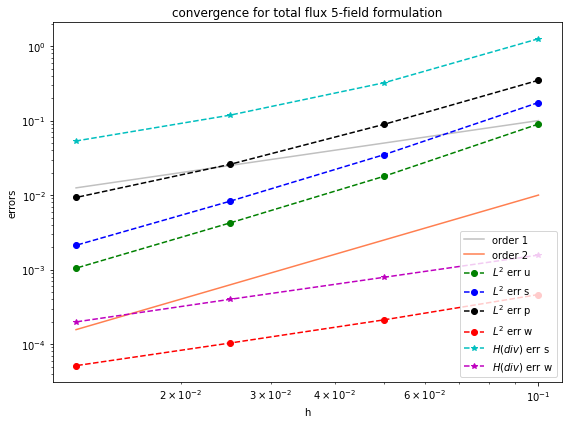

In [ ]:
A_err=np.zeros((6,4))

for i in range(4):
    n = 5*(2**i)
    dt = 0.2/(4**i)
    l2err_u, l2err_s, l2err_p, l2err_w, Hdiverr_s, Hdiverr_w = solve_biot4s(n, dt, T, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2)

    A_err[0,i] = l2err_u 
    A_err[1,i] = l2err_s
    A_err[2,i] = l2err_p 
    A_err[3,i] = l2err_w
    A_err[4,i] = Hdiverr_s
    A_err[5,i] = Hdiverr_w

    print('n={} l2err_u={:.2e} l2err_s={:.2e} l2err_p={:.2e} l2err_w={:.2e}'.format(n, l2err_u, l2err_s, l2err_p, l2err_w))
    print('dt={} Hdiverr_s={:.2e} Hdiverr_w={:.2e} '.format(dt, Hdiverr_s, Hdiverr_w))
    print()
    
# definition of the meshsize 
h = np.array([0.1/(2**i) for i in range(4)])

# we use the subplots axis layout managers in matplotlib
fig, axes = plt.subplots(figsize=(8,6))

axes.loglog(h, h, 'silver',label="order 1")
axes.loglog(h, h**2, 'coral',label="order 2")
axes.loglog(h, A_err[0,:], 'g--o',label="$L^2$ err u")
axes.loglog(h, A_err[1,:], 'b--o',label="$L^2$ err s")
axes.loglog(h, A_err[2,:], 'k--o',label="$L^2$ err p")
axes.loglog(h, A_err[3,:], 'r--o',label="$L^2$ err w")
axes.loglog(h, A_err[4,:], 'c--*',label="$H(div)$ err s")
axes.loglog(h, A_err[5,:], 'm--*',label="$H(div)$ err w")

axes.set_title("convergence for total flux 5-field formulation");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.tight_layout()
plt.show()

### 5-field formulation with total stress (Lee)

In [ ]:
def solve_biot5t(n, dt, T, lam, c_0, kappa, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2):
    # 0. method specific pre-computations
    beta = 1.0/(2*(1.0+lam))
    gamma = lam/(4*(1.0+lam))
    c_1 = c_0 + 1.0/(1.0+lam)
    
    # 1. mesh generation
    #mesh = UnitSquareMesh(n, n, 'crossed')
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    mesh = generate_mesh(square, n)

    # 2. definition of the lowest-order weak symmetry MFE coupling
    S1 = FiniteElement('RT', mesh.ufl_cell(), 1)
    S2 = FiniteElement('BDM', mesh.ufl_cell(), 1)
    U = VectorElement('DG', mesh.ufl_cell(), 0)
    Q = FiniteElement('DG', mesh.ufl_cell(), 0)
    W = FiniteElement('RT', mesh.ufl_cell(), 1)
    P = FiniteElement('DG', mesh.ufl_cell(), 0)
    X = FunctionSpace(mesh, MixedElement([S1, S2, U, Q, W, P]))

    # 3. assembling     
    s1, s2, u, q, w, phi = TrialFunctions(X)
    t1, t2, v, r, z, psi = TestFunctions(X)

    x_old = Function(X)
    s1_old, s2_old, u_old, q_old, w_old, phi_old = split(x_old)

    a1 = (0.5 * (dot(s1, t1)+dot(s2, t2)) - gamma * (s1[0]+s2[1]) * (t1[0]+t2[1])) * dx
    a2 = (u[0] * div(t1) + u[1] * div(t2) - v[0] * div(s1) - v[1] * div(s2)) * dx
    a3 = beta * ((t1[0]+t2[1]) * phi + (s1[0]+s2[1]) * psi) * dx
    a4 = ((dt/kappa) * dot(w, z) + c_1 * phi * psi) * dx
    a5 = dt *(psi * div(w) - phi * div(z))  * dx
    a6 = (r * (s1[1] - s2[0]) - q * (t1[1] - t2[0])) * dx
    a = a1 + a2 + a3 + a4 + a5 + a6
    
    L = (dt*(g1+g2)*psi + dot(f1+f2,v) + (c_1*phi_old+beta*(s1_old[0]+s2_old[1]))*psi) * dx

    # 4. solve and advance in time 
    A = assemble(a)
    Ainv = LUSolver(A)

    # 5. error evaluation
    l2err_u = 0.0
    l2err_s = 0.0
    Hdiverr_s = 0.0
    l2err_p = 0.0
    l2err_w = 0.0
    Hdiverr_w = 0.0
    
    Y = FunctionSpace(mesh, 'DG', 1)
    l2err_q = 0.0
    
    for t in np.arange(dt, T+0.1*dt, dt):
        f1.time = t
        f2.time = t
        g1.time = t
        g2.time = t
        b = assemble(L)
        
        print('solving time {}'.format(t))
        Ainv.solve(x_old.vector(), b)
        s1_old, s2_old, u_old, q_old, w_old, phi_old = x_old.split()

        u_ex.time = t
        p_ex.time = t
        s1_ex.time = t
        s2_ex.time = t
        w_ex.time = t
        l2err_u = max(l2err_u, errornorm(u_ex, u_old, 'L2'))
        l2err_s += dt * (errornorm(s1_ex, s1_old, 'L2')**2)
        l2err_s += dt * (errornorm(s2_ex, s2_old, 'L2')**2)
        Hdiverr_s += dt * (errornorm(s1_ex, s1_old, 'Hdiv0')**2)
        Hdiverr_s += dt * (errornorm(s2_ex, s2_old, 'Hdiv0')**2)
        l2err_p = max(l2err_p, errornorm(p_ex, phi_old, 'L2'))
        l2err_w += dt * (errornorm(w_ex, w_old, 'L2')**2)
        Hdiverr_w += dt * (errornorm(w_ex, w_old, 'Hdiv0')**2)
        
        qproj = project(s1_old[1] - s2_old[0], Y)
        l2err_q += dt * (norm(qproj, 'L2')**2)
    
    l2err_s = sqrt(l2err_s)
    Hdiverr_s = sqrt(Hdiverr_s)
    l2err_w = sqrt(l2err_w)
    Hdiverr_w = sqrt(Hdiverr_w)
    l2err_q = sqrt(l2err_q)
    
    return l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w

In [ ]:
M2_err=np.zeros((7, 4))

for i in range(4):
    n = 10*(2**i)
    dt = 0.2/(2**i)
    l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w = solve_biot5t(n, dt, T, lam, c_0, kappa, u_ex, p_ex, s1_et, s2_et, w_et, f1, f2, g1, g2)

    M2_err[0,i] = l2err_u 
    M2_err[1,i] = l2err_s
    M2_err[2,i] = l2err_p 
    M2_err[3,i] = l2err_w
    M2_err[4,i] = l2err_q
    M2_err[5,i] = Hdiverr_s
    M2_err[6,i] = Hdiverr_w

    print('n={} l2err_u={:.2e} l2err_s={:.2e} l2err_p={:.2e} l2err_w={:.2e}'.format(n, l2err_u, l2err_s, l2err_p, l2err_w))
    print('dt={} l2err_q={:.2e} Hdiverr_s={:.2e} Hdiverr_w={:.2e} '.format(dt, l2err_q, Hdiverr_s, Hdiverr_w))
    print()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/lib/python3/dist-packages/FIAT/check_format_variant.py:10: DeprecationWarning: Variant of BDM element will change from point evaluation to integral evaluation. You should project into variant="integral"
  ' You should project into variant="integral"', DeprecationWarning)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
solving time 0.2
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
solving time 0.4
solving time 0.6000000000000001
n=10 l2err_u=1.39e-01 l2err_s=8.96e-01 l2err_p=4.91e-01 l2err_w=1.09e-03
dt=0.2 l2err_q=5.20e-01 Hdiverr_s=4.56e+00 Hdiverr_w=6.96e-02 

Calli

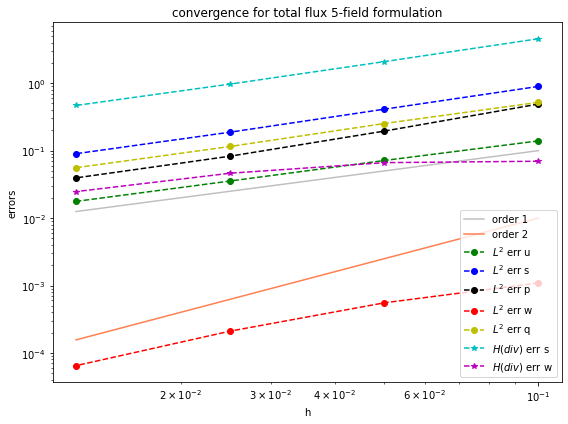

In [ ]:
# definition of the meshsize 
h = np.array([0.1/(2**i) for i in range(4)])

# we use the subplots axis layout managers in matplotlib
fig, axes = plt.subplots(figsize=(8,6))

axes.loglog(h, h, 'silver',label="order 1")
axes.loglog(h, h**2, 'coral',label="order 2")
axes.loglog(h, M2_err[0,:], 'g--o',label="$L^2$ err u")
axes.loglog(h, M2_err[1,:], 'b--o',label="$L^2$ err s")
axes.loglog(h, M2_err[2,:], 'k--o',label="$L^2$ err p")
axes.loglog(h, M2_err[3,:], 'r--o',label="$L^2$ err w")
axes.loglog(h, M2_err[4,:], 'y--o',label="$L^2$ err q")
axes.loglog(h, M2_err[5,:], 'c--*',label="$H(div)$ err s")
axes.loglog(h, M2_err[6,:], 'm--*',label="$H(div)$ err w")

axes.set_title("convergence for total flux 5-field formulation");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.tight_layout()
plt.show()